# Cambridge Data Science Hack

<div class="alert alert-block alert-info">
<h3>You do not have to work in this Notebook, but a read-through may provide some helpful hints.</h3>
<h4>Introduction</h4>
<p>This challenge focuses on extracting meaning from text. Use cases in a finance company could include:</p>
<ul>
 <li>Automatic chatbots</li>
 <li>Classifying customer complaints and communications</li>
 <li>Automated underwriting from medical records</li>
 <li>Automated claims handling from accident reports and call transcripts</li>
 </ul>
 
<p>Here we will use data from government e-petitions to explore two common uses of text in Data Science:</p>
<ul>
 <li>Predictive Modelling</li>
 <li>Topic Classification</li>
 </ul>
 
<br></br>
<p>You may wish to work in this Notebook for your solution. But feel free to use any coding language, any approach, any GUI.</p>
 <br></br>
<p>_Contains Parliamentary information licensed under the Open Parliament Licence v3.0._
https://www.parliament.uk/site-information/copyright/open-parliament-licence/</p>
</div>

## A look at the data

We'll start by importing all the packages we might need.

In [1]:
import json
import numpy as np
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import pyLDAvis
import plotly.express as px
from sklearn.utils import resample
from operator import itemgetter
import seaborn as sns
import gensim
from nltk.stem import PorterStemmer,WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\gensim\corpora\dictionary.py:11: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\gensim\models\doc2vec.py:73: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\nltk\decorators.py:68: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object dire

## Preparing the Data

#### Loading Data
We have training and holdout data. You'll need to use the training data to create a model and then use your model to label the holdout data.

In [4]:
with open('training_data.json', 'rb') as f:
    training_data = json.load(f)

with open('holdout_data.json', 'rb') as f:
    holdout_data = json.load(f)

Let's look at the first petition in our training set, and have a look at how many petitions and signatures we're dealing with.

In [5]:
print(training_data[0])

print("\nNumber of petitions in training data: {}".format(len(training_data)))
print("\nMean number of signatures: {}".format(int(np.mean([p['numberOfSignatures'] for p in training_data]))))
print("\nMedian number of signatures: {}".format(int(np.median([p['numberOfSignatures'] for p in training_data]))))

{'abstract': {'_value': 'MPs should attend all debates, not merely turn up and vote or strike pairing deals. With other commitments, a five day Commons is not workable for MPs: I suggest three full days (9am to 6pm minimum), with one or two days for Committees, leaving at least one day for constituency work.'}, 'label': {'_value': 'Reform the Commons: Three days full time with compulsory attendance for all MPs.'}, 'numberOfSignatures': 27}

Number of petitions in training data: 12387

Mean number of signatures: 3777

Median number of signatures: 58


We can see that the petition text is stored under two keys - the _value_ of _label_ gives the petition title, and the _value_ of _abstract_ provides a longer description.

<div class="alert alert-block alert-warning">
<h4>Cleaning the Text</h4>
<p>Usually in a Data Science problem we would start with Exploratory Data Analysis (EDA). But this is unstructured text - we can't calculate simple statistics or plot interesting histograms until we have turned this text into numbers. Before thinking about making a model, <b>structure and clean the text</b>.</p>
<br></br>
<p>You could consider:</p>
<ul>
    <li>Tokenizing</li>
 <li>Lemmatizing or Stemming</li>
 <li>Filtering</li>
 <li>Calculating TF-IDF</li>
 </ul>
 
<p>Packages of use may include:</p>
<ul>
 <li>NLTK</li>
 <li>Gensim</li>
 <li>Sklearn</li>
 </ul>
 
<p>Any blog post about any form of text modelling will begin with a section on text preprocessing. Some examples are here:</p>
<ul>
 <li>https://medium.com/@annabiancajones/sentiment-analysis-of-reviews-text-pre-processing-6359343784fb</li>
 <li>https://www.machinelearningplus.com/nlp/gensim-tutorial/#8howtocreatethetfidfmatrixcorpusingensim</li>
 <li>https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089</li>
 <li>https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925</li>
 </ul>

</div>

In [6]:
# First we create three separate lists to hold the tilte, abstract and number of signatures
# separately for better workability

petition_titles = []
petition_abstracts = []
petition_signs = []
for petition in training_data:
    title = petition['label']['_value']
    abstract = petition['abstract']['_value']
    sign = petition['numberOfSignatures']
    petition_titles.append(title)
    petition_abstracts.append(abstract)
    petition_signs.append(sign)

In [7]:
print(petition_titles[0])
print(petition_abstracts[0])
print(petition_signs[0])

Reform the Commons: Three days full time with compulsory attendance for all MPs.
MPs should attend all debates, not merely turn up and vote or strike pairing deals. With other commitments, a five day Commons is not workable for MPs: I suggest three full days (9am to 6pm minimum), with one or two days for Committees, leaving at least one day for constituency work.
27


In [8]:
#Preprocess function


import nltk, re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

stop_words = stopwords.words('english')
normalizer = WordNetLemmatizer()

def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

def preprocess_text(text):
    cleaned = re.sub(r'\W+', ' ', text).lower()
    tokenized = word_tokenize(cleaned)
    normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    return normalized

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
processed_petition_titles = [preprocess_text(title) for title in petition_titles]
processed_petition_abstracts = [preprocess_text(abstract) for abstract in petition_abstracts]

In [13]:
print(processed_petition_titles[0])
print(processed_petition_abstracts[0])

['reform', 'the', 'common', 'three', 'day', 'full', 'time', 'with', 'compulsory', 'attendance', 'for', 'all', 'mp']
['mp', 'should', 'attend', 'all', 'debate', 'not', 'merely', 'turn', 'up', 'and', 'vote', 'or', 'strike', 'pair', 'deal', 'with', 'other', 'commitment', 'a', 'five', 'day', 'common', 'be', 'not', 'workable', 'for', 'mp', 'i', 'suggest', 'three', 'full', 'day', '9am', 'to', '6pm', 'minimum', 'with', 'one', 'or', 'two', 'day', 'for', 'committee', 'leave', 'at', 'least', 'one', 'day', 'for', 'constituency', 'work']


In [14]:
# stop words removal
stop_words = set(stopwords.words('english'))

titles_no_stops = []
for title in processed_petition_titles:
    text_no_stops = [word for word in title if word not in stop_words]
    titles_no_stops.append(text_no_stops)
    
abstracts_no_stops = []
for abstract in processed_petition_abstracts:
    text_no_stops = [word for word in abstract if word not in stop_words]
    abstracts_no_stops.append(text_no_stops)

In [15]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dataset = titles_no_stops
dct = Dictionary(dataset)  # fit dictionary
corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format

model = TfidfModel(corpus)  # fit model
vector = model[corpus[0]]  # apply model to the first corpus document

In [18]:
vector

[(0, 0.43623983516828463),
 (1, 0.3493107693548095),
 (2, 0.25721792657190506),
 (3, 0.27236885266264543),
 (4, 0.2943652968707102),
 (5, 0.27861651087027495),
 (6, 0.32478383902247365),
 (7, 0.4596259837109637),
 (8, 0.25751167711509415)]

In [19]:
# putting together the cleaned up words into one single string so that sklearn's tf-idf can accept it

cleaned_titles = []
for item in titles_no_stops:
    concat=''
    for word in item:
        concat+=word+' '
    cleaned_titles.append(concat)
    
cleaned_abstracts = []
for item in abstracts_no_stops:
    concat=''
    for word in item:
        concat+=word+' '
    cleaned_abstracts.append(concat)

In [21]:
print(cleaned_titles[0])
print(cleaned_abstracts[0])

reform common three day full time compulsory attendance mp 
mp attend debate merely turn vote strike pair deal commitment five day common workable mp suggest three full day 9am 6pm minimum one two day committee leave least one day constituency work 


<div class="alert alert-block alert-info">
<h4>Challenge Part I: Predict Whether a Petition Surpasses 50 Signatures</h4>
<p>You need to create a model to <b>predict whether a petition has surpassed 50 signatures, using only the petition text as input</b>.</p>
<br></br>
<p>Your first task will probably be feature generation. You may wish to consider:</p>
<ul>
 <li>Word counts</li>
 <li>Word frequencies (and TF-IDF)</li>
 <li>Word embedding</li>
 <li>Custom rules</li>
 </ul>
 

<p>This is a supervised learning task using text - multiple blog posts cover walkthroughs for various purposes (e.g. sentiment analysis). Some potential resources are here:</p>
<ul>
 <li>https://medium.com/@annabiancajones/sentiment-analysis-on-reviews-feature-extraction-and-logistic-regression-43a29635cc81</li>
 <li>https://www.kaggle.com/arunava21/word2vec-and-random-forest-classification</li>
 </ul>
<br></br>
<p>Once you have a model, <b>predict whether each petition in the holdout set will surpass 50 signatures</b>. Your predictions will be assessed against the truth using the F1 score. F1 accounts for both Precision (of all the petitions you predict to surpass 50 signatures, how often were you correct) and Recall (of all the petitions which surpass 50 signatures, how many do you correctly identify).</p>
<br></br>
<p>Your submission for Part I should be a CSV list of 3,000 Booleans to represent your predictions for the holdout set - True if you think a petition will surpass 50 signatures, False otherwise.</p>
</div>

In [24]:
# running tf-idf vectorizer for titles only
title_vectorizer = TfidfVectorizer(norm=None)
titles_vectors = title_vectorizer.fit_transform(cleaned_titles)

In [52]:
titles_vectors.shape

(12387, 8428)

In [25]:
# running tf-idf vectorizer for abstracts only
abstract_vectorizer = TfidfVectorizer(norm=None)
abstracts_vectors = abstract_vectorizer.fit_transform(cleaned_abstracts)

In [53]:
abstracts_vectors.shape

(12387, 15331)

In [26]:
# word embeddings
nlp = spacy.load('en_core_web_md')
titles_embeddings = np.array([nlp(title).vector for title in cleaned_titles])
abstracts_embeddings = np.array([nlp(abstract).vector for abstract in cleaned_abstracts])


In [55]:
titles_embeddings.shape

(12387, 300)

In [48]:
# checking the sentiment of the abstracts
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
abstract_sentiments = []
for abstract in cleaned_abstracts:
    abstract_sentiments.append(sid.polarity_scores(abstract)['compound'])
abstract_sentiments = np.array(abstract_sentiments)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
abstract_sentiments = abstract_sentiments.reshape((12387,1))

In [147]:
from sklearn.decomposition import LatentDirichletAllocation

In [149]:
lda = LatentDirichletAllocation(learning_method='online', n_components=100)
lda_titles = lda.fit_transform(titles_vectors)

In [64]:
X = np.hstack((titles_embeddings, abstracts_embeddings, abstract_sentiments))

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(petition_signs), test_size=0.2)

In [84]:
y_train_c = []
for i in y_train:
    if i > 50:
        y_train_c.append(1.)
    else:
        y_train_c.append(0.0)

        
y_test_c = []
for i in y_test:
    if i > 50:
        y_test_c.append(1.)
    else:
        y_test_c.append(0.0)

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(601, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)


In [102]:
model.fit(x = X_train, y=np.array(y_train_c), validation_data=(X_test, np.array(y_test_c)), batch_size=500, epochs=400, callbacks=[early_stop])

Train on 9909 samples, validate on 2478 samples
Epoch 1/400
9909/9909 [==============================] - 1s 81us/sample - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6831 - val_accuracy: 0.5569
Epoch 2/400
9909/9909 [==============================] - 0s 48us/sample - loss: 0.6709 - accuracy: 0.5891 - val_loss: 0.6847 - val_accuracy: 0.5706
Epoch 3/400
9909/9909 [==============================] - 0s 37us/sample - loss: 0.6581 - accuracy: 0.6108 - val_loss: 0.7071 - val_accuracy: 0.5593
Epoch 4/400
9909/9909 [==============================] - 0s 37us/sample - loss: 0.6441 - accuracy: 0.6283 - val_loss: 0.7312 - val_accuracy: 0.5440
Epoch 5/400
9909/9909 [==============================] - 0s 37us/sample - loss: 0.6393 - accuracy: 0.6511 - val_loss: 0.6674 - val_accuracy: 0.5912
Epoch 6/400
9909/9909 [==============================] - 0s 37us/sample - loss: 0.6019 - accuracy: 0.6789 - val_loss: 0.7180 - val_accuracy: 0.5617
Epoch 7/400
9909/9909 [==============================] - 0s 37us

In [150]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             multiple                  361802    
_________________________________________________________________
dense_71 (Dense)             multiple                  240800    
_________________________________________________________________
dense_72 (Dense)             multiple                  120300    
_________________________________________________________________
dense_73 (Dense)             multiple                  60200     
_________________________________________________________________
dense_74 (Dense)             multiple                  10050     
_________________________________________________________________
dense_75 (Dense)             multiple                  51        
Total params: 793,203
Trainable params: 793,203
Non-trainable params: 0
_______________________________________________

In [ ]:
lr.predict()

In [ ]:
RC.score(X_valid, y_valid)

In [105]:
holdout_titles = []
holdout_abstracts = []
for petition in holdout_data:
    title = petition['label']['_value']
    abstract = petition['abstract']['_value']
    holdout_titles.append(title)
    holdout_abstracts.append(abstract)

In [106]:
processed_holdout_titles = [preprocess_text(title) for title in holdout_titles]
processed_holdout_abstracts = [preprocess_text(abstract) for abstract in holdout_abstracts]

In [107]:
# stop words removal
h_titles_no_stops = []
for title in processed_holdout_titles:
    text_no_stops = [word for word in title if word not in stop_words]
    h_titles_no_stops.append(text_no_stops)
    
h_abstracts_no_stops = []
for abstract in processed_holdout_abstracts:
    text_no_stops = [word for word in abstract if word not in stop_words]
    h_abstracts_no_stops.append(text_no_stops)

In [108]:
# putting together the cleaned up words into one single string so that sklearn's tf-idf can accept it

h_cleaned_titles = []
for item in h_titles_no_stops:
    concat=''
    for word in item:
        concat+=word+' '
    h_cleaned_titles.append(concat)
    
h_cleaned_abstracts = []
for item in h_abstracts_no_stops:
    concat=''
    for word in item:
        concat+=word+' '
    h_cleaned_abstracts.append(concat)

In [109]:
h_titles_vectors = title_vectorizer.transform(h_cleaned_titles)
h_abstracts_vectors = abstract_vectorizer.transform(h_cleaned_abstracts)

In [110]:
h_titles_embeddings = np.array([nlp(title).vector for title in h_cleaned_titles])
h_abstracts_embeddings = np.array([nlp(abstract).vector for abstract in h_cleaned_abstracts])

In [112]:
h_abstract_sentiments = []
for abstract in h_cleaned_abstracts:
    h_abstract_sentiments.append(sid.polarity_scores(abstract)['compound'])


In [114]:
h_abstract_sentiments = np.array(h_abstract_sentiments)

In [116]:
h_abstract_sentiments.shape

(3000,)

In [117]:
h_abstract_sentiments = h_abstract_sentiments.reshape((3000,1))

In [118]:
X_holdout = np.hstack((h_titles_embeddings, h_abstracts_embeddings, h_abstract_sentiments))

In [119]:
y_pred = model.predict(X_holdout)

In [122]:
y_pred

array([[0.68803775],
       [0.550133  ],
       [0.17852445],
       ...,
       [0.7103156 ],
       [0.3142619 ],
       [0.4927123 ]], dtype=float32)

In [125]:
y_pred.reshape((3000,))

array([0.68803775, 0.550133  , 0.17852445, ..., 0.7103156 , 0.3142619 ,
       0.4927123 ], dtype=float32)

In [136]:
predictions = []
for i in y_pred:
    if i>0.05:
        predictions.append(True)
    else:
        predictions.append(False)

In [137]:
predictions = np.array(predictions)

In [138]:
predictions = predictions.reshape((3000,1))

In [139]:
import pandas as pd

df = pd.DataFrame(predictions)

In [140]:
df.to_csv('predictions.csv')

<div class="alert alert-block alert-info">
<h4>Challenge Part II: Topic Modelling</h4>
<p>In many problems it is useful to cluster texts together which seem to talk about the same topic. You may wish to understand what customers tend to complain about, what news articles tend to be about or what reviews tend to talk about. For this task, <b>you need to automatically group the petitions into topics.</b>.</p>
<br></br>
<p>On the hack day you will show us your topic classification and explain how you have decided - quantiatively or qualitatively - on your end result.</p>
<br></br>
<p>You may wish to consider:</p>
<ul>
 <li>LDA</li>
 <li>Clustering</li>
 </ul>

In [188]:
from gensim import corpora, models

# list_of_list_of_tokens = [["a","b","c"], ["d","e","f"]]
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...
dictionary_LDA = corpora.Dictionary(titles_no_stops)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in titles_no_stops]

num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 8.07 s


In [189]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.089*"referendum" + 0.072*"vote" + 0.068*"eu" + 0.053*"uk" + 0.049*"age" + 0.034*"hold" + 0.030*"allow" + 0.025*"16" + 0.024*"lower" + 0.024*"election"

1: 0.050*"force" + 0.036*"keep" + 0.034*"child" + 0.030*"abuse" + 0.024*"improve" + 0.024*"remain" + 0.023*"right" + 0.021*"without" + 0.018*"armed" + 0.018*"veteran"

2: 0.033*"stop" + 0.032*"drink" + 0.031*"area" + 0.027*"put" + 0.027*"hospital" + 0.026*"patient" + 0.022*"nh" + 0.022*"cancer" + 0.022*"deal" + 0.020*"000"

3: 0.053*"pay" + 0.051*"service" + 0.049*"stop" + 0.043*"government" + 0.037*"nh" + 0.026*"fund" + 0.025*"aid" + 0.023*"cut" + 0.020*"tax" + 0.018*"urge"

4: 0.042*"state" + 0.034*"uk" + 0.029*"pension" + 0.026*"work" + 0.025*"scheme" + 0.022*"refugee" + 0.021*"prevent" + 0.019*"apply" + 0.019*"industry" + 0.018*"create"

5: 0.085*"ban" + 0.047*"legal" + 0.047*"uk" + 0.040*"use" + 0.039*"sale" + 0.031*"make" + 0.023*"requirement" + 0.023*"council" + 0.021*"non" + 0.021*"plastic"

6: 0.052*"year" + 0.034*"act" + 

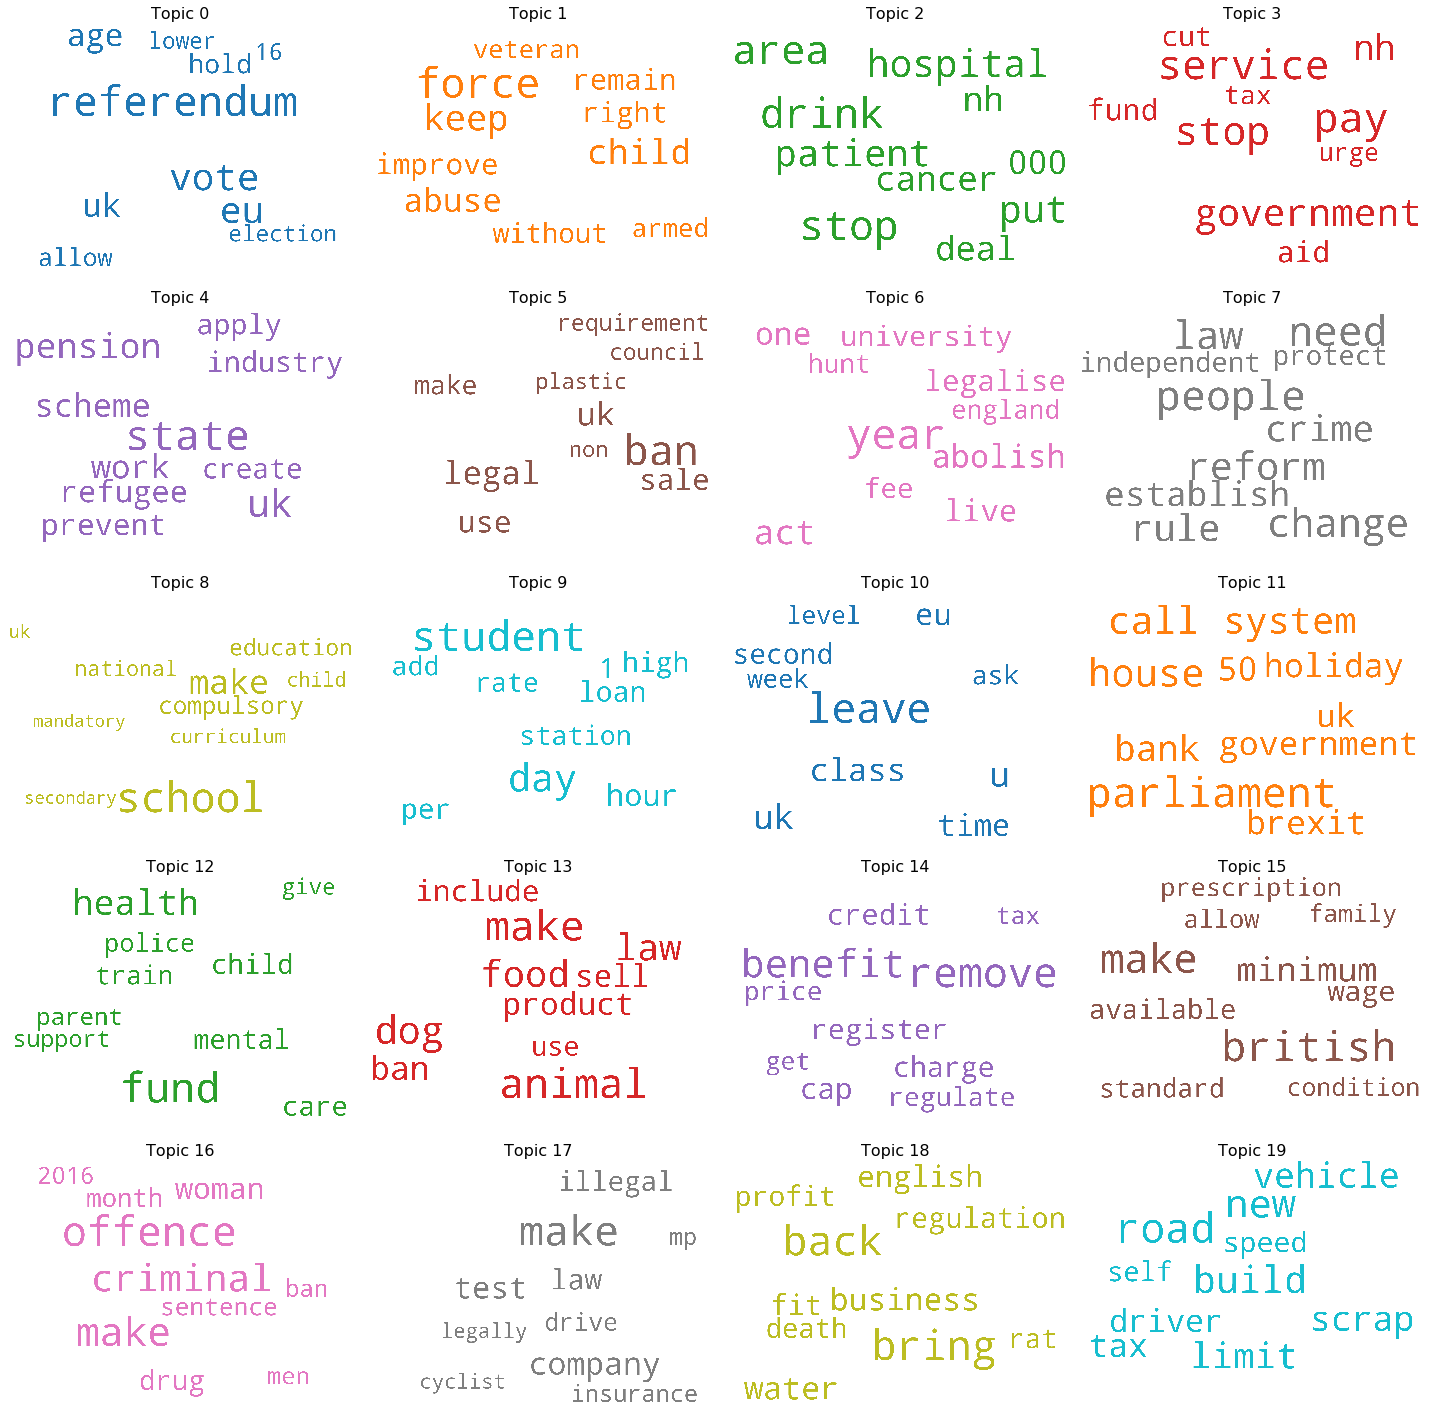

In [198]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]+[color for name, color in mcolors.TABLEAU_COLORS.items()] # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
width=2500,
height=1800,
max_words=20,
colormap='tab10',
color_func=lambda *args, **kwargs: cols[i],
prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics = 20, formatted=False)

fig, axes = plt.subplots(5, 4, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [195]:
topic_words

{'school': 0.12862372,
 'make': 0.07679944,
 'compulsory': 0.03513664,
 'education': 0.030951312,
 'national': 0.027217653,
 'child': 0.023081329,
 'curriculum': 0.022043124,
 'uk': 0.01960951,
 'secondary': 0.017035155,
 'mandatory': 0.017003568}

In [ ]:
lda_model[corpus[0]] # corpus[0] means the first document.

In [175]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)